## Описание проекта
Онлайн-магазин по продаже компьютерных игр планирует провести в 2017 году рекламную кампанию по продвижению своих продуктов. Для поиска перспективных платформ и игр необходимо проанализировать статистику продаж. Нбор данных представлен до декабря 2016 года.

Задачи:
- в динамике по годам определить объемы продаж по играм и платформам,
- выявить определяющие успешность игры закономерности: 
    - определить популярные платформы,
    - как влияют отзывы пользователей и критиков на продажи,
    - какие жанры популярны,
    - составить портрет пользователя каждого региона,
    - сравнить средние пользовательские рейтинги платформ Xbox One и PC,
    - сравнить средние пользовательские рейтинги жанров Action и Sports.
    
Описание полей датасета:
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB

### Начало проекта

#### Подключаемые библиотеки

In [1]:
import pandas as pd # для работы с источниками данных
import numpy as np # для присвоения значения NaN
import matplotlib.pyplot as plt # для визуализации
import seaborn as sb # библиотека доп графики
import scipy.stats as st # блок статистики
from IPython.display import display, HTML # для отображения таблиц в ряд

#### Константы проекта

In [2]:
ALPHA = 0.05  # задаю p-value для проверки гипотиз

#### Блок функций

In [3]:
def mf_box_range(series, scale=1.5):
    """ Функция по расчету диапазона диаграммы размаха (нижнее и верхнее значение доверительного интервала) для столбца
        series - столбец (Series) данных
        scale - коэффициент уса
        Выходные данные:
            квартиль 1
            квартиль 3
            нижняя граница доверительного интервала
            верхняя граница доверительного интервала
            доля строк за границами доверительного интервала в %
            среднеарфметическое по всем данным
            среднеарфметическое в пределах доверительного интервала
    """
    ser = series.describe() # получение стат характеристик по полученной выборке
    q1 = ser['25%'] # первый квартиль
    q3 = ser['75%'] # третий квартиль
    min_range = q1-scale*(q3-q1) # минимальное значение уса
    max_range = q3+scale*(q3-q1) # максимальное значение уса
    if min_range < ser['min']: min_range = ser['min']; # корректировка по данным
    if max_range > ser['max']: max_range = ser['max']; # корректировка по данным
    
    # доля строк за границами доверительного интервала
    out_share = round(100-len(series[(series>=min_range)&(series<=max_range)])*100/len(series),1) 
    
    mean_all = series.mean() # среднеарфметическое по всем данным
    
    # среднеарфметическое в пределах доверительного интервала
    mean_range = series[(series>=min_range)&(series<=max_range)].mean() 
    
    index_list = ['q1', 'q3', 'min_range', 'max_range', 'out_share', 'mean_all', 'mean_range']
    data_list = [q1, q3, min_range, max_range, out_share, mean_all, mean_range]
    return pd.DataFrame(index=index_list, data={'Значения показателей':data_list})


def mf_df_info(m_df):
    """ Получение детальных сведений о полях DataFrame 
        =======================================================
        m_df: передается анализируемый DataFrame
        возвращаемое значение: DataFrame с описанием всех полей
    """
    field_names = ['Наименование поля', 'Тип данных', 'Первое непустое значение','Кол-во пустых значений'\
                   , '% пустых значений', 'Кол-во уникальных значений' ]
    row=[]
    table = []
    print('Размерность источника данных: ', m_df.shape)
    print('\nПервые пять строк датасета:')
    display(m_df.head(5))
    for i in m_df.columns:
        if 1:
            row = []
            row.append(i) # 1
            row.append(str(type(m_df[~m_df[i].isna()].reset_index()[i][0]))) # 2
            row.append(m_df[m_df[i].notna()].reset_index()[i][0]) # 3
            row.append(int(m_df[i].isna().sum())) # 4
            row.append(round(m_df[i].isna().mean() * 100,1)) # 5
            row.append(len(m_df[i].unique())) # 6            
        table.append(row)
    return (pd.DataFrame(data=table, columns=field_names)).sort_values(by='Тип данных', ascending=True)


def mf_dt_optimization(df):
    """
    Data preprocessing
    Pandas DataFrame (df) digital column types optimization
    -----------------
    return(
        memory before optimization in bytes
        memory after optimization in bytes
        compression ratio %
    )
    """
    mem=[df.memory_usage('deep').sum()] # mem before optimization in bytes
    types=['int8', 'int16', 'int32', 'int64', 'uint8', 'uint16', 'uint32', 'uint64', 'float']
    for col in df.select_dtypes(types).columns:
        if ((df[col]%1).abs().sum() == 0 and df[col].isna().sum()==0): # int/uint 
            if df[col].min() < 0: # int
                df[col] = pd.to_numeric(df[col], downcast='integer')
            else: # uint
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
        else: # float
            df[col] = pd.to_numeric(df[col], downcast='float')
    mem.append(df.memory_usage('deep').sum()) # mem after optimization in bytes
    mem.append(round(mem[1]/mem[0],1)) # compression ratio
    return mem

def mf_display_side_by_side(dfs:list, captions:list, space=3):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
        space: количество пробелов между таблицами
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        for i in range(space):
            output += "\xa0"
    display(HTML(output))


## Общая информация о данных

### Анализ структуры датасета

In [4]:
df_games = pd.read_csv('games.csv') # чтение данных
df_games.columns = ( # названия столбцов сразу привожу к нижнему регистру и змеиному формату
    [x.lower().replace(' ', '_') for x in df_games.columns] 
)
mf_df_info(df_games) # сведения по структуре таблицы

Размерность источника данных:  (16715, 11)

Первые пять строк датасета:


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


,Наименование поля,Тип данных,Первое непустое значение,Кол-во пустых значений,% пустых значений,Кол-во уникальных значений
2,year_of_release,<class 'numpy.float64'>,2006.0,269,1.6,38
4,na_sales,<class 'numpy.float64'>,41.36,0,0.0,402
5,eu_sales,<class 'numpy.float64'>,28.96,0,0.0,307
6,jp_sales,<class 'numpy.float64'>,3.77,0,0.0,244
7,other_sales,<class 'numpy.float64'>,8.45,0,0.0,155
8,critic_score,<class 'numpy.float64'>,76.0,8578,51.3,83
0,name,<class 'str'>,Wii Sports,2,0.0,11560
1,platform,<class 'str'>,Wii,0,0.0,31
3,genre,<class 'str'>,Sports,2,0.0,13
9,user_score,<class 'str'>,8,6701,40.1,97


In [5]:
# пропуски в столбцах year_of_release, name, genre
x = (
        df_games.year_of_release.isna()
        |df_games.name.isna()
        |df_games.genre.isna()
    ).mean()
print(f"Доля пустых строк по полям год, наименование, жанр игр: {x:.2%}")

Доля пустых строк по полям год, наименование, жанр игр: 1.62%


In [6]:
df_games.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


### Анализ полных дубей

In [7]:
# проверка на наличие полных дублей
print(f"Количество полных дублей в данных: { df_games.duplicated().sum()}") 

Количество полных дублей в данных: 0


### Выводы
- year_of_release после удаления пропусков можно преобразовать к целочисленному типу для оптимизации структуры датасета,
- user_score - числовые оценки пользователей представлены строковым типом, необходимо проанализировать значения столбца и преобразовать к числовому типу,
- пропуски сразу по трем столбцам year_of_release, name, genre не превышают 1,6%, их можно удалить,
- пропуски по столбцам critic_score, user_score, rating составляют более 40% от всех строк выборки, удалить такие строки нельзя, но и заменить их каким-то значением тоже нельзя, т.к. значение рейтинга является исключительно индивидуальным признаком для конкретной игры и не может быть расчитано на основе значений других столбцов.

## Предобработка данных

### Анализ значений столбца user_score

In [8]:
y=[]
for x in df_games.query("user_score==user_score").user_score.unique():
    if not(x.replace('.','').isnumeric()):
        y.append(x)
         
print("Найдены нечисловые значения: ", y)
print(f"Доля строк с нечисловыми значениями: {len(df_games.query('user_score in @y'))/len(df_games):.1%}")

Найдены нечисловые значения:  ['tbd']
Доля строк с нечисловыми значениями: 14.5%


Вероятно значение 'tbd' означает 'to be determined' - предстоит определить, что равносильно пустому значению, в связи с чем его необходимо заменить на NaN.

In [9]:
# замена значения tbd на пустое значение
df_games.user_score.replace(to_replace='tbd', value=np.nan, inplace=True)

### Анализ значений столбца rating

In [10]:
df_games.rating.value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

**Промежуточный вывод:**
- значения столбца rating являются нечисловыми, а категориальными, поэтому пропуски данных можно заменить на значение "unknown".

### Обработка пропусков в данных

In [11]:
# пропуски сразу по трем полям year_of_release, name, genre не превышают 1,7%, их можно удалить
x = (
        df_games.year_of_release.isna()
        |df_games.name.isna()
        |df_games.genre.isna()
    )
print(f"Должно быть удалено: {x.sum()} строк")

Должно быть удалено: 271 строк


In [12]:
print(f"Строк удалится: {df_games.shape[0] - df_games.dropna(subset=['year_of_release','name','genre']).shape[0]}")
df_games.dropna(subset=['year_of_release','name','genre'], inplace=True)
print(f"Осталось строк: {df_games.shape[0]}")

Строк удалится: 271
Осталось строк: 16444


In [13]:
df_games.rating.fillna('unknown', inplace=True)

### Замена типов данных

In [14]:
# преобразую столбец user_score к числовому типу
df_games.user_score = df_games.user_score.astype('float64')

# --- выполняю оптимизацию типов столбцов
print("\n ==========  Cтруктура датафрейма до оптимизации:")
df_games.info()

res = mf_dt_optimization(df_games)

print("\n ==========  Cтруктура датафрейма после оптимизации:")
df_games.info()

print(f"\n\nОбъем данных до оптимизации {res[0]/1024:.1f} Kb" )
print(f"\nОбъем данных после оптимизации {res[1]/1024:.1f} Kb" )
print(f"\nСтепень сжатия данных: {res[2]:.1%}" )


 ==========  Cтруктура датафрейма до оптимизации:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
dtypes: float64(7), object(4)
memory usage: 1.5+ MB

 ==========  Cтруктура датафрейма после оптимизации:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-N

In [15]:
# перестраиваю индекс датафрейма
df_games.reset_index(drop=True, inplace=True)

### Расчеты и добавление резульатов

In [16]:
# добавление суммарных продаж по всем регионам (мировые продажи): Северной Америке, Европы, Японии и другим странам
df_games['total_sales'] = df_games['na_sales'] + df_games['eu_sales'] + df_games['jp_sales'] + df_games['other_sales']

### Выводы
* строки с пропусками данных по полям name, year_of_release, genre были удалены, т.к. их доля составила 1,6%, 
* пропуски по полю name возможно случайны, по полю year_of_release - наверное, невозможно точно определить год выпуска, по полю genre - игра может сочетать в себе несколько жанров, поэтому указать конкретное значение невозможно,
* в поле rating найдено значение "tbd" - to be determined (доля строк с этим значение составила 14,5%, которое не несет никакой информации о величине оценки, мешает преобразовать поле к числовому формату данных, в связи с чем, это значение было заменено на пустое,
* возможно отсутствие оценок и рейтинга для игр связано с недостатком иниформации по игре (очень мало оценок критиков и игроков), либо наоборот - с избытком противоречивых оценок,
* преобразование типов данных столбцов таблицы снизило объем занимаемой памяти с 1.5 до 1 Кбайт (степень сжатия данных 70%),
* рассчитан итоговый объем продаж по Севереной Америке, Европе, Японии и другим странам, результат добавлен в источник данных (столбец other_sales).

## Анализ данных

### Динамика продаж игр

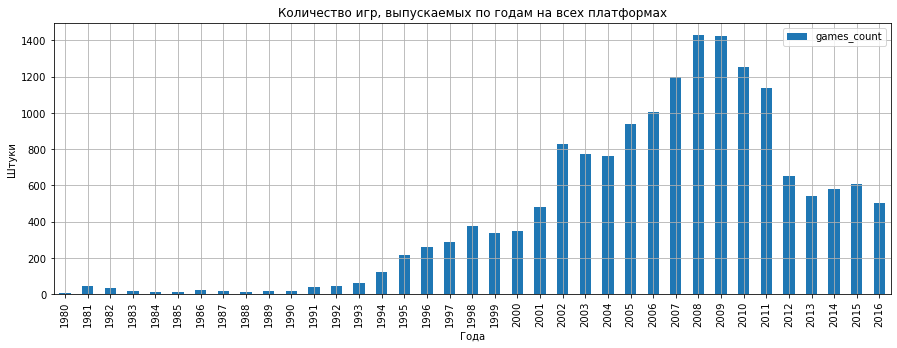

In [17]:
# подготовка источника данных
df_temp = (
    pd.DataFrame(df_games['year_of_release'].value_counts())
    .reset_index(drop=False)
    .rename(mapper={'index':'year', 'year_of_release':'games_count'}, axis=1)
    .sort_values(by='year')
    .reset_index(drop=True)
)

# построение гистограммы
ax = df_temp.plot(kind='bar', x='year', y='games_count', figsize=(15,5), grid=True
             , title='Количество игр, выпускаемых по годам на всех платформах')
ax.set_ylabel("Штуки")
ax.set_xlabel("Года");

**Промежуточные выводы**
- Как видно из графика выхода новых игр до 1993 года индустрия компьютерных развлечений находится в зачаточном состоянии.
- Заметный рост количества игр отмечается с 1993 по 2008 год. С 2009 по 2011 год заметно снижение выпуска, а в 2012 году резкое падение (почти в 2 раза по сравнению с максимальным объемом в 2008-2009 годы).

**Продажы игр по платформам в динамике по годам**

In [18]:
# готовлю срез данных: объем продаж игр по платформам в динамике по годам
df_platform_years = (
    df_games.pivot_table(index=['platform', 'year_of_release'], values='total_sales', aggfunc='sum')
    .reset_index(drop=False)
)

# нахожу среднюю продолжительность "жизни" платформ - количество лет, в которых выпускались игры по платформам
print("Медианная оценка средней продолжительности жизни платформ: ", df_platform_years['platform'].value_counts().median())

Медианная оценка средней продолжительности жизни платформ:  7.0


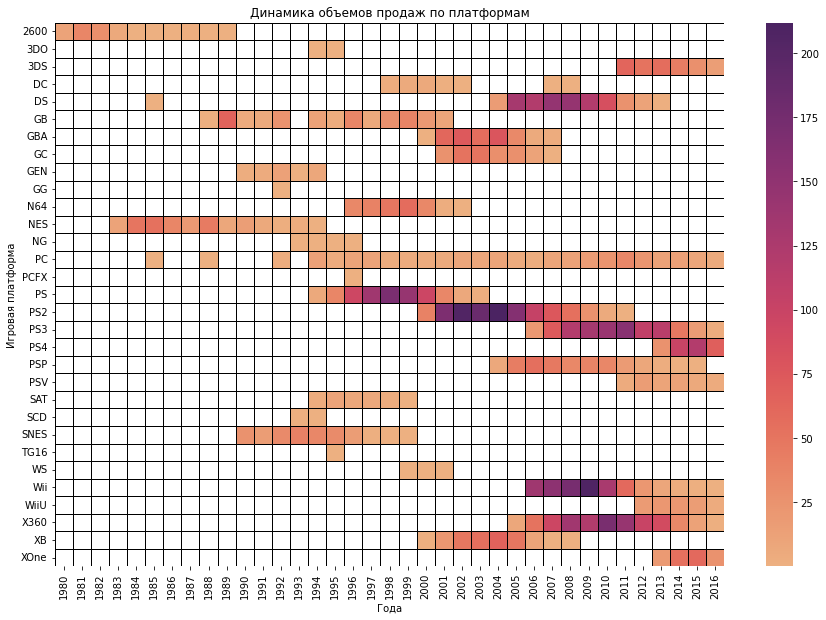

In [19]:
# ---------- Динамика объемов продаж по платформам

# данные для графика
df_temp = (
    df_platform_years.pivot_table(index=['year_of_release', 'platform'], values='total_sales', aggfunc='sum')
    .reset_index(drop=False)
    .pivot('year_of_release','platform','total_sales')
    .T
)

# строю график
plt.figure(figsize = (15,10))
ax1 = sb.heatmap(df_temp,cmap="flare",linewidth=.5, linecolor='black'); #viridis, crest
ax1.set(title='Динамика объемов продаж по платформам', xlabel='Года', ylabel='Игровая платформа');

**Промежуточные выводы:**
- актуальный период для анализа и прогноза выберу как половину медианной оценки средней продолжительности жизни платформы, т.е. 4 года: с 2013 по 2016 гг.
- для дальнейшего анализа целесообразно брать данные только по платформам, у которых есть продажи за актуальный период и за текущий год.

In [20]:
# задаю актуальный период
AP = list(range(2013,2017))

In [21]:
# задаю темный фон
sb.set_theme(style="darkgrid")

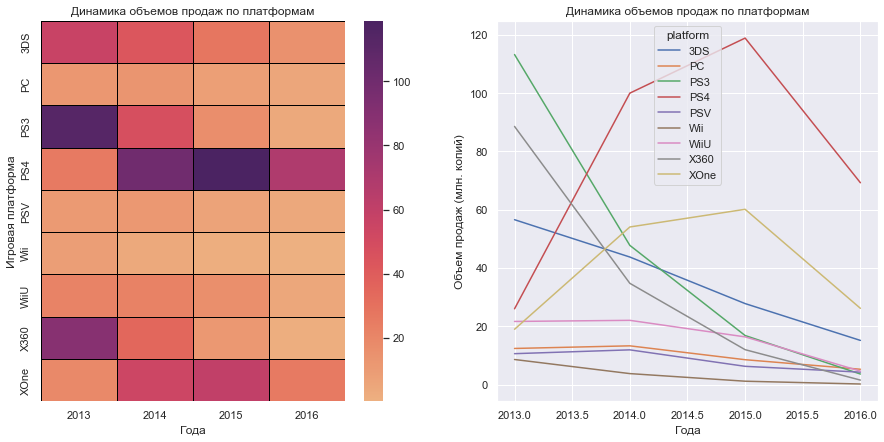

In [22]:
# платформы за актуальный период
pl_list = list(df_platform_years[df_platform_years.year_of_release == 2016].platform.unique()) 

fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# --- данные для графика
df_temp= (
    df_games.query("platform in @pl_list and year_of_release in @AP")
    .pivot_table(index=['year_of_release', 'platform'], values='total_sales', aggfunc='sum')
    .reset_index(drop=False)
    .pivot('year_of_release','platform','total_sales')
    .T
)

df_temp2 = (
    df_games.query("platform in @pl_list and year_of_release >= 2013")
    .pivot_table(index=['year_of_release', 'platform'], values='total_sales', aggfunc='sum')
    .reset_index(drop=False)
)
df_temp2.year_of_release = df_temp2.year_of_release.astype('object')

# --- подготовка графиков
# тепловая карта
ax1 = sb.heatmap(df_temp,cmap="flare",linewidth=.5, linecolor='black', ax=ax1); #viridis, crest
ax1.set(title='Динамика объемов продаж по платформам', xlabel='Года', ylabel='Игровая платформа')

# линейный график
ax2 = sb.lineplot(data=df_temp2, x='year_of_release', y='total_sales', hue='platform', ax=ax2)
ax2.set(title='Динамика объемов продаж по платформам', xlabel='Года', ylabel='Объем продаж (млн. копий)');

**Промежуточные выводы:**
- так как данные за 2016 год неполные (по контексту задачи сейчас конец 2016 года), то для выделения платформ с ростом продаж необходимо проанализировать динамику продаж 2015 к 2014 году.

### Топ-5 платформ

In [23]:
# динамика продаж 2015 к 2014 году и общие объемы продаж с 2013 по 2016 годы
df_temp3 = (
df_temp2.query("year_of_release in (2014,2015)")
    .pivot_table(index='platform', columns='year_of_release', aggfunc={'total_sales':sum})
    .droplevel(level=0,axis=1)
    .join(df_temp2.pivot_table(index='platform', aggfunc={'total_sales':sum}))
)

df_temp3['dynamics']= df_temp3.apply(lambda x: round(x[2015]*100/x[2014],1), axis=1)
df_temp3.sort_values(by='total_sales', ascending=False)

,2014,2015,total_sales,dynamics
platform,,,,
PS4,100.000000,118.900002,314.140015,118.9
PS3,47.759998,16.820000,181.429993,35.2
XOne,54.070000,60.139999,159.320007,111.2
3DS,43.759998,27.780001,143.250000,63.5
X360,34.740002,11.960000,136.800003,34.4
WiiU,22.030001,16.350000,64.629997,74.2
PC,13.280001,8.520000,39.430000,64.2
PSV,11.900000,6.250000,32.989998,52.5
Wii,3.750000,1.140000,13.660000,30.4


**Промежуточные выводы:**
- в 2015 году рост продаж к 2014 году отмечается только по двум платформам PS4 (прирост 18,9%), XOne (11,2%),
- по всем прочим платформам наблюдается снижение продаж, однако, исходя из объемов реализованных игр с 2013 по 2016 год, выделяются еще три платформы с достаточно большими объемами: 3DS, PS3, X360,
- итого топ-5 перперспективных платформ: 3DS, PS4, PS3, X360, XOne.

### Продажи по топ-5 платформам

In [24]:
top5_plt = ['PS4', 'PS3', '3DS', 'X360', 'XOne'] # задаю топ-5 платформ

Доля строк-выбросов для платформы PS4: 13.8%
Доля строк-выбросов для платформы PS3: 9.9%
Доля строк-выбросов для платформы 3DS: 13.2%
Доля строк-выбросов для платформы X360: 8.6%
Доля строк-выбросов для платформы XOne: 10.9%


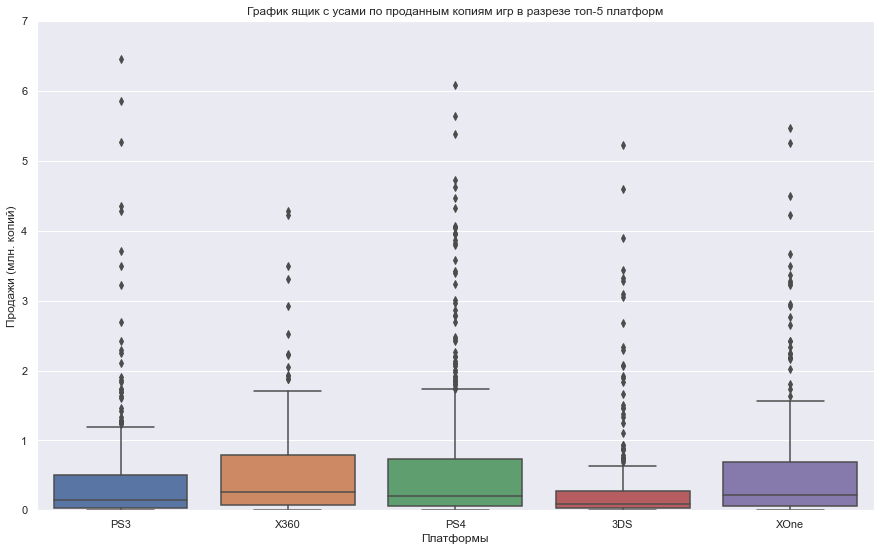

In [25]:
# подготовка данных для анализа
df_temp = (
    df_games.
    query("platform in @top5_plt and year_of_release >= 2013")
)

# расчет доли строк-выбросов
for i in range(len(top5_plt)):
    df_platf = (
        df_temp.query(f"platform=='{top5_plt[i]}'")['total_sales']
    )
    r_min = df_platf.quantile(0.25)
    r_max = df_platf.quantile(0.75)
    iqr = r_max-r_min
    interval = [r_min-1.5*iqr, r_max+1.5*iqr]
    print(f"Доля строк-выбросов для платформы {top5_plt[i]}: {((df_platf<interval[0]) | (df_platf>interval[1])).mean():.1%}")

# подготовка графика
fig = plt.figure(figsize=(15,9))
ax1 = fig.add_subplot(111, title='График ящик с усами по проданным копиям игр в разрезе топ-5 платформ')
sb.boxplot(data=df_temp, x='platform', y='total_sales', ax=ax1)
ax1.set(xlabel='Платформы', ylabel='Продажи (млн. копий)')
plt.ylim(0,7);

**Промежуточные выводы:**
- по всем пяти платформам доля выбросов не превысила 14%, по сути эти выбросы свидетельствуют о каких-то особо популярных играх, на которые был большой спрос,
- эти выбросы не являются "мусорными" и их удалять не нужно.

### Влияние оценок критиков и игроков на продажи

In [26]:
def mf_scatter(df, platform, period):
    """ 
        целевая функция для автоматизации построения графиков рассеяния 
        и расчета корреляции между оценками и объемами продаж
    """
    df_temp=(
        df_games.query("platform==@platform and year_of_release in @AP")
    )
    axs = pd.plotting.scatter_matrix(
        df_temp[['user_score','critic_score', 'total_sales']]
        , figsize = (12,7) 
    );
    #ax1.set_title('Матрица корреляции')
    axs[0][0].figure.suptitle(f'Матрица корреляции (оценки игроков, оценки критиков, продажи игр по платформе {platform}') 

    plt.show()

    print('Коэффициент корреляции между оценками критиков и пользователей: ',
          round(df_temp.critic_score.corr(df_temp.user_score), 2))
    print('Коэффициент корреляции между оценками критиков и объемаи продаж: ',
          round(df_temp.critic_score.corr(df_temp.total_sales), 2))
    print('Коэффициент корреляции между оценками игроков и объемаи продаж: ',
          round(df_temp.user_score.corr(df_temp.total_sales), 2))

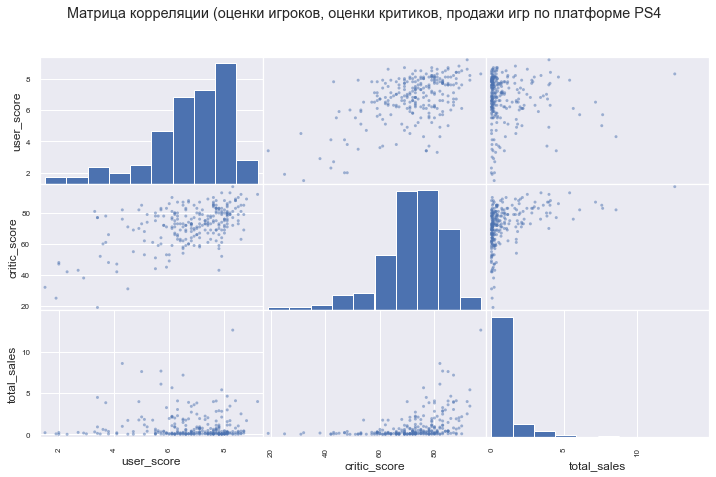

Коэффициент корреляции между оценками критиков и пользователей:  0.56
Коэффициент корреляции между оценками критиков и объемаи продаж:  0.41
Коэффициент корреляции между оценками игроков и объемаи продаж:  -0.03


In [27]:
mf_scatter(df_games, top5_plt[0], AP)

**Промежуточные выводы:**
- на графике прослеживается положительная корреляция между оценками игроков и оценками критиков, характер корреляции нелинейный, в связи с чем коэффициент корреляции Пирсона составил 0.56,
- зависимость продаж от оценок критиков также нелинейна и менее выражена, коэффициен корреляции: 0.41,
- объемы продаж игр напрямую почти не зависит от оценок игроков, коэффициент корреляции: -0.03.

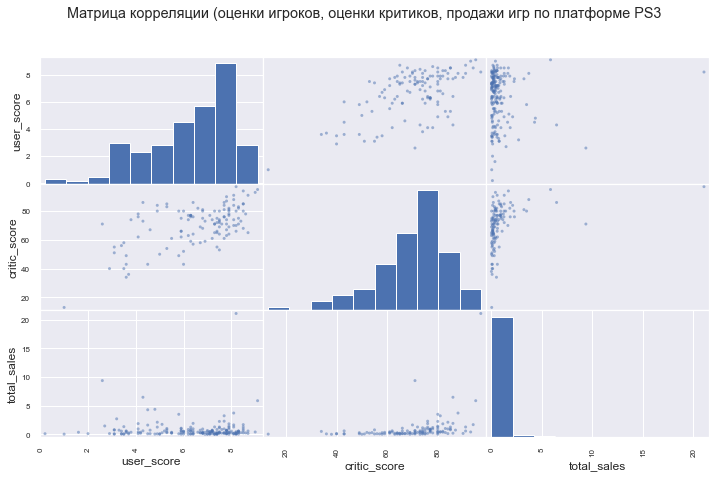

Коэффициент корреляции между оценками критиков и пользователей:  0.6
Коэффициент корреляции между оценками критиков и объемаи продаж:  0.33
Коэффициент корреляции между оценками игроков и объемаи продаж:  0.0


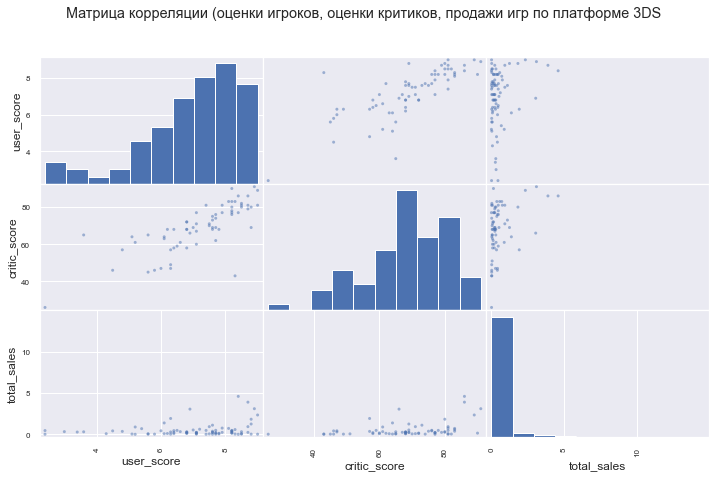

Коэффициент корреляции между оценками критиков и пользователей:  0.77
Коэффициент корреляции между оценками критиков и объемаи продаж:  0.36
Коэффициент корреляции между оценками игроков и объемаи продаж:  0.24


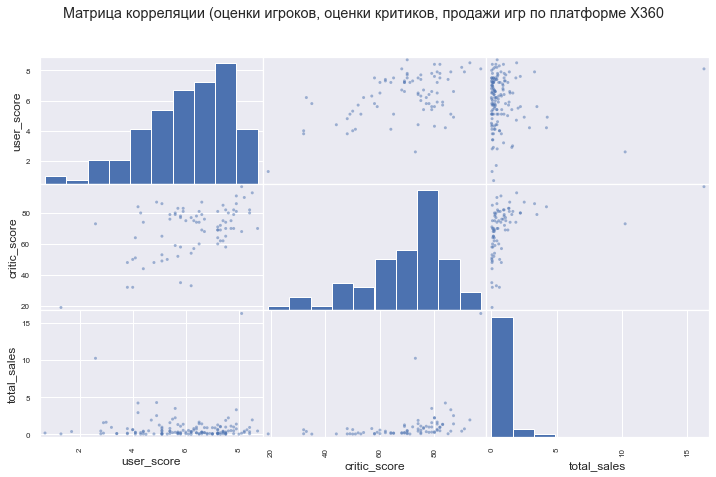

Коэффициент корреляции между оценками критиков и пользователей:  0.52
Коэффициент корреляции между оценками критиков и объемаи продаж:  0.35
Коэффициент корреляции между оценками игроков и объемаи продаж:  -0.01


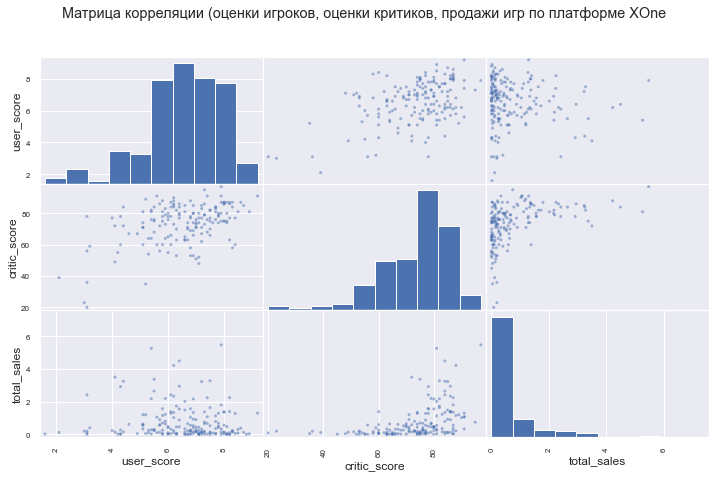

Коэффициент корреляции между оценками критиков и пользователей:  0.47
Коэффициент корреляции между оценками критиков и объемаи продаж:  0.42
Коэффициент корреляции между оценками игроков и объемаи продаж:  -0.07


In [28]:
for i in range(1, len(top5_plt)):
    mf_scatter(df_games, top5_plt[i], AP)

**Промежуточные выводы:**
- по прочим популярным платформам зависимости показателей оценок игроков, критиков и объемов продаж очень похожи с показателями по платформе PS4?
- из рассмотренных показателей все зависимости оказались нелинейны,
- наибольшая зависимость найдена между оценками игроков и критиков, по всем платформам линейный коэффициент корреляции Пирсона оказалася не менее 47%,
-  оценки критиков и игроков слабо влияют на объемы продаж.

### Анализ игр по жанрам

In [29]:
# ==== подготовка данных для анализа

# детальные данные
df_temp = (
    df_games
    .query("year_of_release in @AP") # анализ актуального периода
)

# сводные данные
data = (
    df_temp
    .pivot_table(index='genre', values='total_sales', aggfunc=['sum', 'min', 'max', 'mean', 'median'])
    .droplevel(level=1, axis=1)
    .sort_values(by='sum', ascending=False)
)

data = (
    data.join(df_temp.pivot_table(index='genre', aggfunc={'name':'count'}).rename({'name':'games_count'}, axis=1))
    .reset_index(drop=False)
)

data['mean_sales'] = data['sum']/data.games_count # среднее количество проданных копий на игру
data['share']=data.apply(lambda x: x['sum']/data['sum'].sum(), axis=1) # доля жанров по объему продаж
data['pie_lab'] = data.apply(lambda x: x.genre+' ('+f"{x.share:.1%})", axis=1) # описание для круговой диаграммы
data

,genre,sum,min,max,mean,median,games_count,mean_sales,share,pie_lab
0,Action,321.869995,0.01,21.049999,0.420196,0.110,766,0.420196,0.295107,Action (29.5%)
1,Shooter,232.979996,0.01,14.630000,1.245882,0.450,187,1.245882,0.213608,Shooter (21.4%)
2,Sports,150.649994,0.01,8.580000,0.703972,0.240,214,0.703972,0.138124,Sports (13.8%)
3,Role-Playing,145.889999,0.01,14.599999,0.499623,0.125,292,0.499623,0.133759,Role-Playing (13.4%)
4,Misc,62.820000,0.01,9.180001,0.405290,0.100,155,0.405290,0.057597,Misc (5.8%)
5,Platform,42.630001,0.01,4.320000,0.576081,0.225,74,0.576081,0.039085,Platform (3.9%)
6,Racing,39.889999,0.01,7.090000,0.469294,0.120,85,0.469294,0.036573,Racing (3.7%)
7,Fighting,35.310001,0.01,7.550000,0.441375,0.125,80,0.441375,0.032374,Fighting (3.2%)
8,Adventure,23.639999,0.01,1.660000,0.096490,0.030,245,0.096490,0.021674,Adventure (2.2%)
9,Simulation,21.760000,0.01,5.220000,0.350968,0.100,62,0.350968,0.019951,Simulation (2.0%)


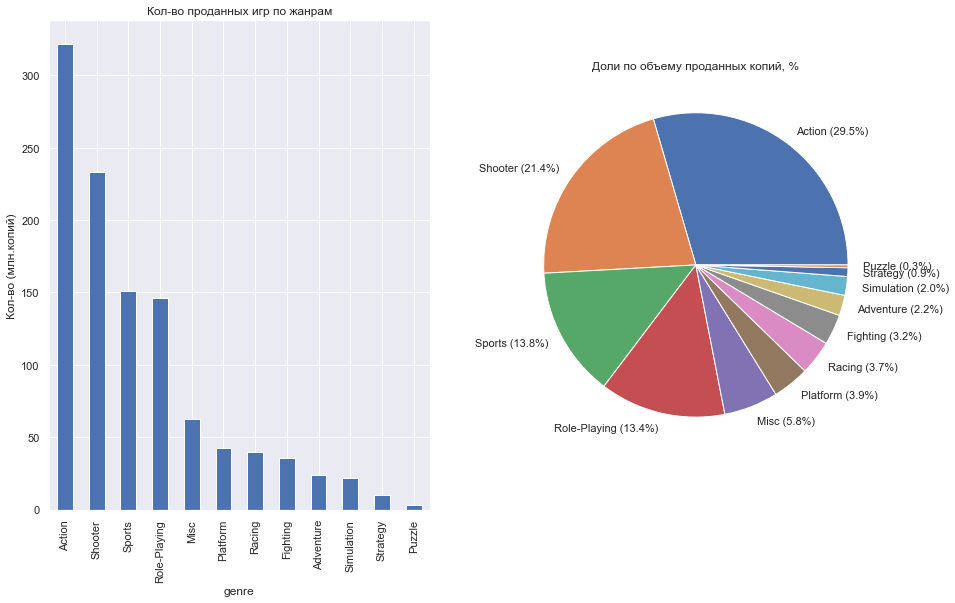

In [30]:
# построение графиков
fig = plt.figure(figsize=(15,9))
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)
    
ax0 = (
        data
        .set_index('genre')['sum']
        .plot(kind='bar', title='Кол-во проданных игр по жанрам', ylabel='Кол-во (млн.копий)', ax=ax0)
)

ax1 = (
        data
        .set_index('pie_lab')['sum']
        .plot(kind='pie', title='Доли по объему проданных копий, %', ylabel='', ax=ax1)
)
plt.show()

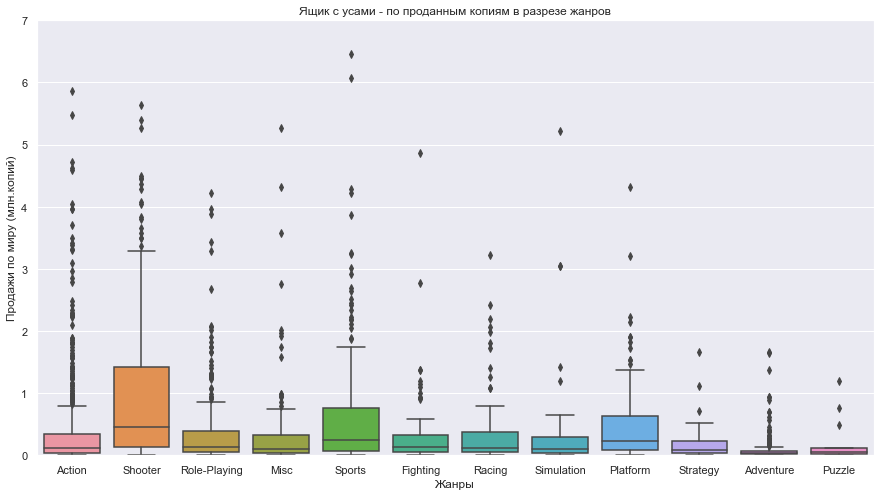

In [31]:
plt.figure(figsize=(15,8))
ax = sb.boxplot(data=df_temp, x='genre', y='total_sales')
ax.set(title='Ящик с усами - по проданным копиям в разрезе жанров', ylabel='Продажи по миру (млн.копий)', xlabel='Жанры')
plt.ylim(0,7);

**Промежуточные выводы:**
- из гистограммы продаж по жанрам видно, что самое большое количество копий игр продано в жанре Action (29,5% от всех проданных копий), далее следует Shooter (21,4%), Sports (13,8%), Role-Playing (13,4%),
- за рассматриваемый период самое большое количество игр было выпущено в жанре Action (766 штук), также этот жанр лидирует в количестве проданных копий (321,9 млн.копий),
- при этом на жанр Shooter приходится самое большое среднее (медианное) количество проданных копий по миру объемом в 450 тыс. копий, в то время как на жанр Action - меньше 110 тыс. копий,
- по жанру Sports количество проданных игр составило 150,6 млн. копий, что уступает только жанрам Action и Shooter, значение медианы продаж этого жанра - 240 тыс. копий (второе значение после жанра Shooter),
- из графика "ящик с усами" по проданным копиям игр видно, что в жанрах Action, Role-Playing, Sports, Adventure присутствует достаточно много выбросов превышающих значение верхнего уса, что свидетельствует наличии в этих жанрах достаточно популярных игр.

### Портрет игрока по регионам

In [32]:
def mf_get_top5(column):
    """ целевая функция по поиску топ-5 значений передаваемого столбца с самым большим объемом продаж """
    data = (
        df_temp.pivot_table(index=column, values=['na_sales','eu_sales','jp_sales'], aggfunc=sum)
        .reset_index()
        .melt(id_vars = column ,value_vars=['na_sales','eu_sales','jp_sales'], var_name='region')
        .sort_values(by=['region','value'], ascending=[True, False])
    )

    mf_display_side_by_side(
        [data.query("region=='na_sales'").set_index(column).drop('region',axis=1).head(5)
        ,data.query("region=='eu_sales'").set_index(column).drop('region',axis=1).head(5)
        ,data.query("region=='jp_sales'").set_index(column).drop('region',axis=1).head(5)]
        , ['Северная Америка','Европа','Япония'], 5
    )

#### Топ-5 платформ по регионам

In [33]:
mf_get_top5('platform')

,value
platform,
PS4,108.739998
XOne,93.120003
X360,81.659996
PS3,63.500000
3DS,38.200001
,value
platform,
PS4,141.089996
PS3,67.809998


**Промежуточные выводы:**
- в Северной Америке и Европе лидирующей платформой по количеству проданных копий игр за актуальный период стала PS4, также в пятерку платформ по этим двум регионам вошли XOne, X360, PS3, 3DS,
- в Японии самой популярной платформой оказалась 3DS (эта платформа в Америке и Европе находится на пятом месте), PS4 и PS3 заняли только соответственно четвертое и второе место; также в пятерку региона вошли PSV и WiiU, которых нет в топ-5 Америки и Европы.

#### Топ-5 жанров по регионам

In [34]:
mf_get_top5('genre')

,value
genre,
Action,126.050003
Shooter,109.739998
Sports,65.269997
Role-Playing,46.400002
Misc,27.490000
,value
genre,
Action,118.129997
Shooter,87.860001


**Промежуточные выводы:**
- предпочтения игроков Америки и Европы по игровым жанрам также оказались похожи по первым четырем позициям, самым популярным оказался Action, далее Shooter, Sports, Role-Playing,
- наибольшей популярностью игроков из Японии пользуется жанр Role-Playing (в Америке и Европе жанр на четвертом месте), Action - только на втором месте, а Shooter - на пятом.

#### Влияние рейтинга на продажи по регионам

In [35]:
mf_get_top5('rating')

# расчеты структуры рейтинга (долей) проданных копий по регионам
data = (
    df_temp
    .pivot_table(index='rating', values=['na_sales','eu_sales','jp_sales'], aggfunc=sum)
)

for i in data.columns:
    data[i]=(data[i])/data[i].sum()

data = (    
    data
    .reset_index()
    .melt(id_vars='rating', value_vars=['na_sales','eu_sales','jp_sales'], var_name='region', value_name='share')
)
data['rating'] = data.apply(lambda x: x.rating+f" ({x.share:.1%})", axis=1)
data = data.set_index('rating')

,value
rating,
M,165.210007
unknown,89.419998
E,79.050003
E10+,54.240002
T,49.790001
,value
rating,
M,145.320007
E,83.360001


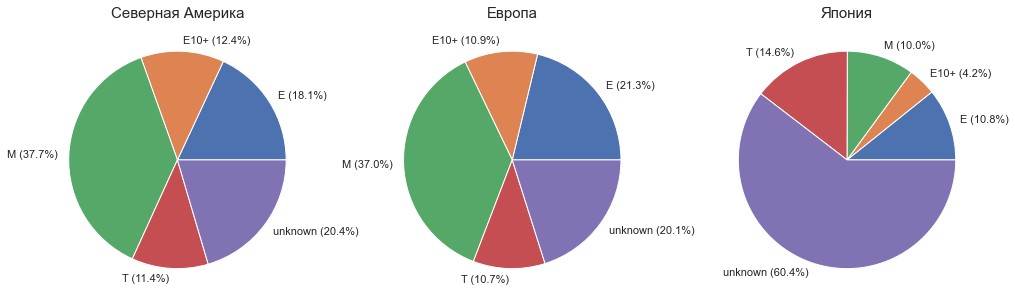

In [36]:
fig=plt.figure(figsize=(17,5))
axs=[]
regions=['na_sales','eu_sales','jp_sales']
regions2=['Северная Америка','Европа','Япония']
for i in regions:
    axs.append(fig.add_subplot(1,len(regions), len(axs)+1))
    axs[len(axs)-1] = (
        data.query("region==@i")
        .plot(kind='pie', y='share', title=i, ylabel='', ax=axs[len(axs)-1], legend=False)
    )
for i in range(3): 
    axs[i].set_title(regions2[i], size=15)

**Промежуточные выводы:**
- несомненно, рейтинг ESRB влияет на объемы продаж, примечательно, что структура продаж Америки и Европы очень близка: на рейтинг "Е" приходится около 20% от всех проданных копий региона, "Е10+" - 11%, "М" - 37%, "Т" - 11%,
- в Америке и Европе самая большая доля вструктуре принадлежит рейтингу "M", на негоприходится по 37% продаж соответственно,
- структура продаж по рейтингу ESRB в Японии сильно отличается от Америки и Европы, так на долю рейтинга "М" приходится только 10% от всех проданных копий; у более половины (60%) копий рейтинг не указан.

### Проверка статистических гипотез

In [37]:
def mf_stat_check(field, var_list, equal_variance):
    """ 
        Целевая функция для графического анализа распределения оценок пользователей по заданному признаку,
        подсчет статтеста: двусторонний парный t-test
    """

    # задаю словарь выборок для анализа
    df_1 = df_games.query(f"{field} == '{var_list[0]}' and year_of_release in @AP")['user_score'].dropna()
    df_2 = df_games.query(f"{field} == '{var_list[1]}' and year_of_release in @AP")['user_score'].dropna()
    print(f"\nКоличество элементов в выборке '{var_list[0]}': {len(df_1)}, в выборке '{var_list[1]}': {len(df_2)}\n")
    print(f"\nДисперсия выборки '{var_list[0]}': {df_1.var()}, выборки '{var_list[1]}': {df_2.var()}\n")
    
    voc1 = ({var_list[0]:df_1, var_list[1]:df_2})

    # --- графический анализ распределений оценок по двум платформам (гистограмма распределения)
    fig, axs = plt.subplots(1,2, figsize=(15,6))
    fig.suptitle('Гистограмма распределения оценок')
    i=0
    for name in voc1:
        # проверка на нормальность распределения по qq-графикам
        sb.histplot(x=voc1[name], stat='density', bins= 30, kde=True, element='poly', ax=axs[i])
        axs[i].set(title=name)
        i+=1

    # --- графический анализ распределений оценок по двум платформам (qq-графики)
    fig, axs = plt.subplots(1,2, figsize=(15,6))
    fig.suptitle('qq-графики распределения оценок')
    i=0
    for name in voc1:
        # проверка на нормальность распределения по qq-графикам
        st.probplot(voc1[name], plot=axs[i]) 
        axs[i].set(title=name)
        i+=1

    plt.show();

    # --- проверка стат гипотезы
    print(" ------  Проверка гипотизы")
    results = st.ttest_ind(df_1, df_2, equal_var=equal_variance) # по умолчанию двусторонний тест

    if (results.pvalue < ALPHA):
        print(f"Отвергаем нулевую гипотезу на уровне статзначимости {results.pvalue:2%}" +
              ", найдено статистически значемое различие.")
    else:
        print(f"Не получилось отвергнуть нулевую гипотезу на уровне статзначимости {results.pvalue:.2%}")

#### Гипотеза №1 

Средние пользовательских рейтингов платформ XOne и PC одинаковые:
* нулевая гипотеза - среднее оценок пользователей по платформам XOne и PC совпадают,
* альтернативная гипотеза - среднее оценок пользователей по платформам XOne и PC отличаются (двусторонняя гипотеза).


Количество элементов в выборке 'XOne': 182, в выборке 'PC': 155


Дисперсия выборки 'XOne': 1.906996726989746, выборки 'PC': 3.0358927249908447



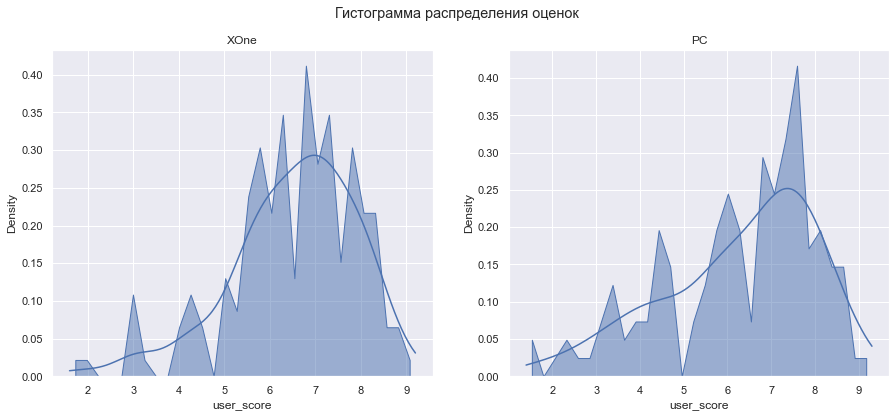

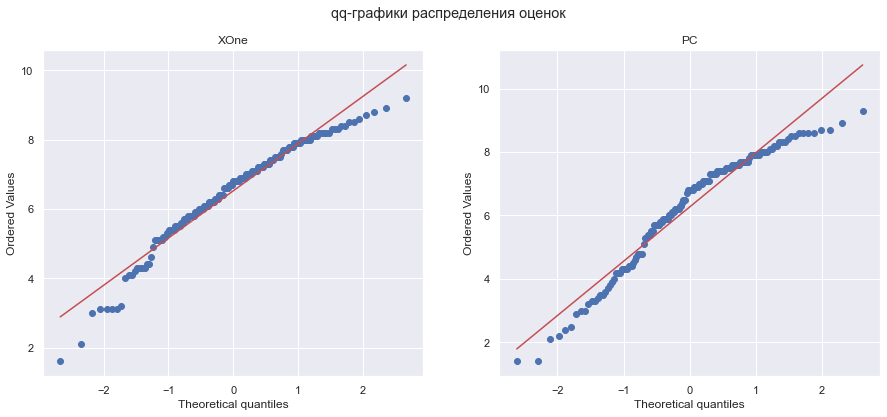

 ------  Проверка гипотизы
Не получилось отвергнуть нулевую гипотезу на уровне статзначимости 14.76%


In [38]:
mf_stat_check('platform', ['XOne','PC'], False)

**Промежуточные выводы:**
* в каждой из выборок более 30 элементов, что дает основание применить параметрический t-test,
* дисперсии выборок различны, для выборки 'XOne': 1.9, для выборки 'PC': 3.03, в связи с чем t-test проведен с поправкой equal_var = False,
* исходя из графиков гистограмм и qq-графиков, распределения оценок похожи на нормальное распределение,
* статистически значимых различий на уровне 14% между выборками оценок пользователей по платформам XOne и PC не обнаружено (альтернативную гипотезу не можем отвергнуть).

#### Гипотеза №2

Средние пользовательских рейтингов жанров Action и Sports разные:
* нулевая гипотеза - среднее оценок пользователей по жанрам Action и Sports совпадают,
* альтернативная гипотеза - среднее оценок пользователей по жанрам Action и Sports отличаются (двусторонняя гипотеза).


Количество элементов в выборке 'Action': 389, в выборке 'Sports': 160


Дисперсия выборки 'Action': 1.769359827041626, выборки 'Sports': 3.180612564086914



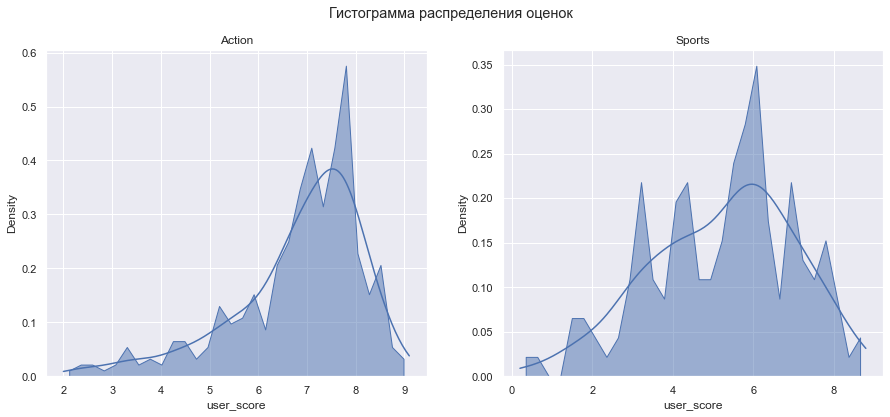

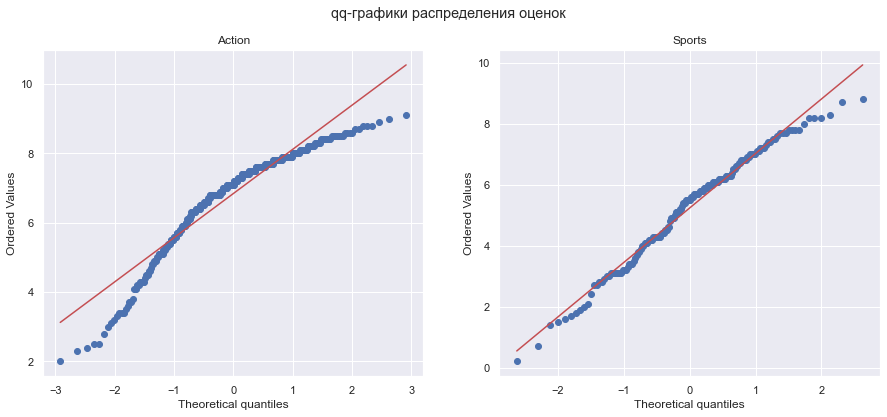

 ------  Проверка гипотизы
Отвергаем нулевую гипотезу на уровне статзначимости 0.000000%, найдено статистически значемое различие.


In [39]:
mf_stat_check('genre',['Action','Sports'], False)

**Промежуточные выводы:**
* в каждой из выборок более 30 элементов, что дает основание применить параметрический t-test,
* дисперсии выборок различны, для выборки 'Action': 1.77, для выборки 'Sports': 3.18, в связи с чем t-test проведен с поправкой equal_var = False,
* исходя из графиков, распределения оценок близки к нормальному распределению,
* найдено статистически значимое различие на уровне 0,0% между выборками по жанрам Action и Sports (нулевая гипотеза отвергнута и принята альтернативная).

### Выводы
- данные по играм представлены с 1980 по 2016 года, с 1994 года отмечается рост продаж игр по сравнению с предыдущими периодами, 
- резкий рост продаж зафиксирован в 2002 году в связи (в лидерах продаж на тот год стали платформы PS2, GBA, XB) и в 2008 году (Wii, XB, DS, PS3), в 2012 году произошло резкое снижение продаж к предыдущему периоду, после чего вплоть до 2016 года объемы приблизились к уровню 2001 года,
- средний период продолжительности платформы по медианной оценке составил 7 лет, в связи с чем за актуальный период анализа данных будут взяты года с 2013 по 2016 (примерно половина продолжительности жизни платформы),
---
- перперспективными топ-5 платформами за актуальный период стали: 3DS, PS4, PS3, X360, XOne,
- доля выбросов проданных копий по этим платформам лежит в диапазоне от 9% до 14%, данные выбросы не являются "мусорными", они свидетельствуют о наличии популярных игр, по которым было продано рекордное количество копий,
---
- влияние оценок критиков на объемы продаж игр по топ-5 платформам небольшая, коэффициен корреляции Пирсона лежит в диапазоне от 33% до 42%, статистическая зависимость показателей носит нелинейный характер,
- оценки игроков почти не влияют на продажи (коэффициен корреляции близок к нулю, зависимость нелинейна),
- отмечена взаимная корреляция между оценками игроков и критиков, значение показателя лежит в пределах от 47% до 77%,
---
- из гистограммы продаж по жанрам видно, что самое большое количество копий игр продано в жанре Action (29,5% от всех проданных копий), далее следует Shooter (21,4%), Sports (13,8%), Role-Playing (13,4%),
- за рассматриваемый период самое большое количество игр было выпущено в жанре Action (766 штук), также этот жанр лидирует в количестве проданных копий (321,9 млн.копий),
- при этом на жанр Shooter приходится самое большое среднее (медианное) количество проданных копий по миру объемом в 450 тыс. копий, в то время как на жанр Action - меньше 110 тыс. копий,
- по жанру Sports количество проданных игр составило 150,6 млн. копий, что уступает только жанрам Action и Shooter, значение медианы продаж этого жанра - 240 тыс. копий (второе значение после жанра Shooter),
- из графика "ящик с усами" по проданным копиям игр видно, что в жанрах Action, Role-Playing, Sports, Adventure присутствует достаточно много выбросов превышающих значение верхнего уса, что свидетельствует наличии в этих жанрах достаточно популярных игр,
---
- в Северной Америке и Европе лидирующей платформой по количеству проданных копий игр за актуальный период стала PS4, также в пятерку платформ по этим двум регионам вошли XOne, X360, PS3, 3DS,
- в Японии самой популярной платформой оказалась 3DS (эта платформа в Америке и Европе находится на пятом месте), PS4 и PS3 заняли только соответственно четвертое и второе место; также в пятерку региона вошли PSV и WiiU, которых нет в топ-5 Америки и Европы,
---
- предпочтения игроков Америки и Европы по игровым жанрам также оказались похожи по первым четырем позициям, самым популярным оказался Action, далее Shooter, Sports, Role-Playing,
- наибольшей популярностью игроков из Японии пользуется жанр Role-Playing (в Америке и Европе жанр на четвертом месте), Action - только на втором месте, а Shooter - на пятом,
---
- несомненно, рейтинг ESRB влияет на объемы продаж, примечательно, что структура продаж Америки и Европы очень близка: на рейтинг "Е" приходится около 20% от всех проданных копий региона, "Е10+" - 11%, "М" - 37%, "Т" - 11%,
- в Америке и Европе самая большая доля вструктуре принадлежит рейтингу "M", на негоприходится по 37% продаж соответственно,
- структура продаж по рейтингу ESRB в Японии сильно отличается от Америки и Европы, так на долю рейтинга "М" приходится только 10% от всех проданных копий; у более половины (60%) копий рейтинг не указан,
---
- при проверке статистических гипотез был выбран t-test, т.к. количество элементов в рассматриваемых выборках более 30 и их распределения похожи на нормальное распределение,
- двусторонняя гипотеза №1: средние пользовательских рейтингов платформ XOne и PC одинаковы на уровне статистической значимости в 14%,
- двусторонняя гипотеза №2: средние пользовательских рейтингов жанров Action и Sports отличаются на уровне статистической значимости в 0,0%.

## Общий вывод
**Предобработка данных**
- загружены и проанализированы структура и типы данных таблицы со сведениями о компьютерных играх,
- полные дубли строк не обнаружены,
- названия столбцов приведены к нижнему регистру,
- пропуски сразу по трем столбцам year_of_release, name, genre не превысили 1,6% от всех строк датасета, такие строки были удалены,
- пропуски по столбцам critic_score, user_score, rating составили более 40% от всех строк датасета, удалить такие строки нельзя, но и заменить их каким-то значением тоже нельзя, т.к. значение рейтинга является исключительно индивидуальным признаком для конкретной игры и не может быть расчитано на основе значений других столбцов,
- преобразование типов данных столбцов таблицы снизило объем занимаемой памяти с 1.5 до 1 Кбайт (степень сжатия данных 70%),

**Анализ динамики продаж по годам**
- данные по играм представлены с 1980 по 2016 года, с 1994 года отмечается рост продаж игр по сравнению с предыдущими периодами, 
- резкий рост продаж зафиксирован в 2002 году в связи (в лидерах продаж на тот год стали платформы PS2, GBA, XB) и в 2008 году (Wii, XB, DS, PS3), в 2012 году произошло резкое снижение продаж к предыдущему периоду, после чего вплоть до 2016 года объемы приблизились к уровню 2001 года,
- средний период продолжительности платформы по медианной оценке составил 7 лет, в связи с чем за актуальный период анализа данных будут взяты года с 2013 по 2016 (примерно половина продолжительности жизни платформы),

**Топ-5 перспективных платформ**
- перперспективными топ-5 платформами за актуальный период стали: 3DS, PS4, PS3, X360, XOne,
- доля выбросов проданных копий по этим платформам лежит в диапазоне от 9% до 14%, данные выбросы не являются "мусорными", они свидетельствуют о наличии популярных игр, по которым было продано рекордное количество копий,

**Влияние оценок критиков и игроков на объемы продаж**
- влияние оценок критиков на объемы продаж игр по топ-5 платформам небольшая, коэффициен корреляции Пирсона лежит в диапазоне от 33% до 42%, статистическая зависимость показателей носит нелинейный характер,
- оценки игроков почти не влияют на продажи (коэффициен корреляции близок к нулю, зависимость нелинейна),
- отмечена взаимная корреляция между оценками игроков и критиков, значение показателя лежит в пределах от 47% до 77%,

**Анализ игр по жанрам**
- из гистограммы продаж по жанрам видно, что самое большое количество копий игр продано в жанре Action (29,5% от всех проданных копий), далее следует Shooter (21,4%), Sports (13,8%), Role-Playing (13,4%),
- за рассматриваемый период самое большое количество игр было выпущено в жанре Action (766 штук), также этот жанр лидирует в количестве проданных копий (321,9 млн.копий),
- при этом на жанр Shooter приходится самое большое среднее (медианное) количество проданных копий по миру объемом в 450 тыс. копий, в то время как на жанр Action - меньше 110 тыс. копий,
- по жанру Sports количество проданных игр составило 150,6 млн. копий, что уступает только жанрам Action и Shooter, значение медианы продаж этого жанра - 240 тыс. копий (второе значение после жанра Shooter),
- из графика "ящик с усами" по проданным копиям игр видно, что в жанрах Action, Role-Playing, Sports, Adventure присутствует достаточно много выбросов превышающих значение верхнего уса, что свидетельствует наличии в этих жанрах достаточно популярных игр,

**Портрет игрока по регионам**
- в Северной Америке и Европе лидирующей платформой по количеству проданных копий игр за актуальный период стала PS4, также в пятерку платформ по этим двум регионам вошли XOne, X360, PS3, 3DS,
- в Японии самой популярной платформой оказалась 3DS (эта платформа в Америке и Европе находится на пятом месте), PS4 и PS3 заняли только соответственно четвертое и второе место; также в пятерку региона вошли PSV и WiiU, которых нет в топ-5 Америки и Европы,
---
- предпочтения игроков Америки и Европы по игровым жанрам также оказались похожи по первым четырем позициям, самым популярным оказался Action, далее Shooter, Sports, Role-Playing,
- наибольшей популярностью игроков из Японии пользуется жанр Role-Playing (в Америке и Европе жанр на четвертом месте), Action - только на втором месте, а Shooter - на пятом,
---
- несомненно, рейтинг ESRB влияет на объемы продаж, примечательно, что структура продаж Америки и Европы очень близка: на рейтинг "Е" приходится около 20% от всех проданных копий региона, "Е10+" - 11%, "М" - 37%, "Т" - 11%,
- в Америке и Европе самая большая доля вструктуре принадлежит рейтингу "M", на негоприходится по 37% продаж соответственно,
- структура продаж по рейтингу ESRB в Японии сильно отличается от Америки и Европы, так на долю рейтинга "М" приходится только 10% от всех проданных копий; у более половины (60%) копий рейтинг не указан,

**Проверка статистических гипотез**
- при проверке статистических гипотез был выбран t-test, т.к. количество элементов в рассматриваемых выборках более 30 и их распределения похожи на нормальное распределение,
- двусторонняя гипотеза №1: средние пользовательских рейтингов платформ XOne и PC одинаковы на уровне статистической значимости в 14%,
- двусторонняя гипотеза №2: средние пользовательских рейтингов жанров Action и Sports отличаются на уровне статистической значимости в 0,0%.